## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP, generate_multioutput_rbf_gp
from lafomo.plot import Plotter, Colours, tight_kwargs
from lafomo.trainers import VariationalTrainer, PreEstimator
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

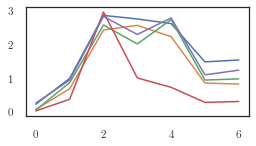

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
from gpytorch.constraints import Positive
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.raw_decay = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_basal = Parameter(0.5 * torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.raw_sensitivity = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    @property
    def decay_rate(self):
        return self.positivity.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.positivity.inverse_transform(value)

    @property
    def basal_rate(self):
        return self.positivity.transform(self.raw_basal)

    @basal_rate.setter
    def basal_rate(self, value):
        self.raw_basal = self.positivity.inverse_transform(value)

    @property
    def sensitivity(self):
        return self.positivity.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.raw_sensitivity = self.decay_constraint.inverse_transform(value)

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        f = self.f
        if not self.pretrain_mode:
            f = self.f[:, :, self.t_index].unsqueeze(2)
            if t > self.last_t:
                self.t_index += 1
            self.last_t = t

        dh = self.basal_rate + self.sensitivity * f - self.decay_rate * h
        return dh

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, 14, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = False
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))

lfm = TranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

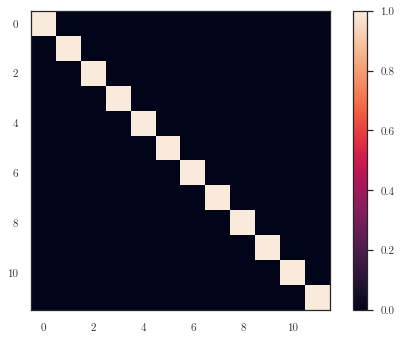

In [5]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()

track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.05)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = PreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)
strat = lfm.gp_model.variational_strategy.base_variational_strategy
dist = strat._variational_distribution
plt.imshow(dist.chol_variational_covar.detach().squeeze())
plt.colorbar()

### Outputs prior to training:

Text(0.5, 1.0, 'Latent')

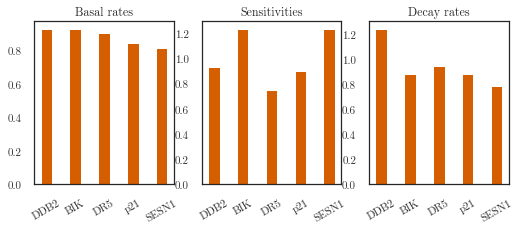

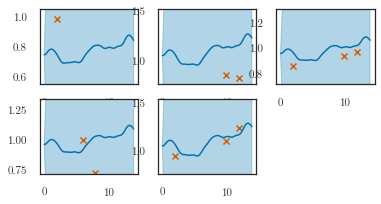

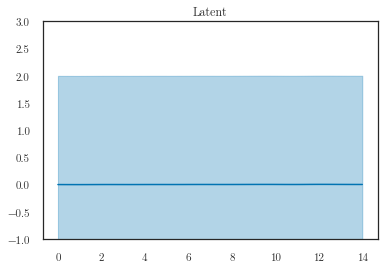

In [6]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)

plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [7]:
def plot_dist():
    dist = lfm.gp_model.variational_strategy.base_variational_strategy._variational_distribution
    mean = dist.natural_vec.detach().squeeze()
    covar = dist.natural_mat.detach().squeeze()
    plt.plot(mean)
    plt.figure()
    plt.imshow(covar)
# plot_dist()

In [8]:
lfm.pretrain(True)
# lfm.loss_fn.num_data = 61
# pre_estimator.train(50, report_interval=20);

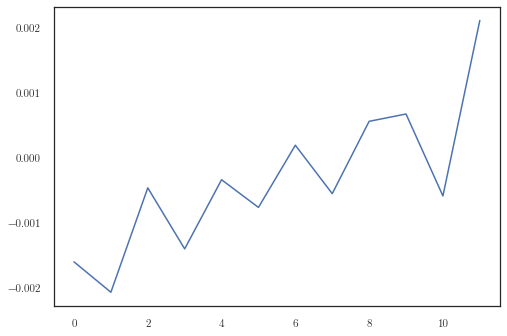

In [9]:
ind = lfm.gp_model
if use_natural:
    ind = dict(ind.named_parameters())['variational_strategy.base_variational_strategy._variational_distribution.natural_vec'].detach()
else:
    ind = dict(ind.named_parameters())['variational_strategy.base_variational_strategy._variational_distribution.variational_mean'].detach()
plt.plot(ind.squeeze())

In [10]:
lfm.pretrain(False)
lfm.loss_fn.num_data = num_training
step_size = 1e-1
trainer.train(50, report_interval=10, step_size=step_size);

Epoch 001/050 - Loss: 8.78 (8.78 0.00) kernel: [[[0.66845965]]]
Epoch 011/050 - Loss: 6.93 (6.55 0.38) kernel: [[[0.541636]]]
Epoch 021/050 - Loss: 6.35 (5.90 0.46) kernel: [[[0.62864107]]]
Epoch 031/050 - Loss: 5.67 (5.05 0.63) kernel: [[[0.7496361]]]
Epoch 041/050 - Loss: 4.97 (3.96 1.01) kernel: [[[0.8877777]]]


In [11]:
tight_kwargs = dict(bbox_inches='tight', pad_inches=0)
t_predict = torch.linspace(0, 15, 80, dtype=torch.float32)

lfm.eval()
q_m = lfm.predict_m(t_predict, step_size=step_size)
q_f = lfm.predict_f(t_predict)

# plotter.plot_losses(trainer, last_x=200)

NanError: cholesky_cpu: 144 of 144 elements of the torch.Size([1, 12, 12]) tensor are NaN.

NameError: name 'exact_q_f' is not defined

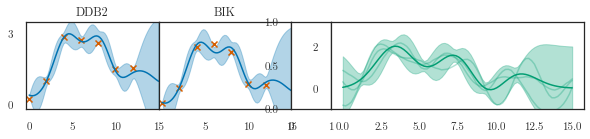

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 1.6),
                         gridspec_kw=dict(width_ratios=[1, 1, 0.3, 1.9], wspace=0))

row = 0
col = 0
ub = [3.5, 3.5]
for i in range(2):
    ax = axes[i]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                    num_samples=0, only_plot_index=i)
    ax.set_ylim([-0.2, ub[i]])
    ax.set_yticks([0, 3])
    ax.set_title(dataset.gene_names[i])
    ax.set_xlim(-0.4, 15)
    if col > 0:
        ax.set_yticks([])
        ax.set_xticks([5, 10, 15])

    col += 1
plotter.plot_gp(q_f, t_predict, ax=axes[3],
                ylim=(-1, 3.2),
                num_samples=3,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
plotter.plot_gp(exact_q_f, t_predict, ax=axes[3],
                ylim=(-1, 3.2), color=Colours.line_color,
                shade_color='red')
axes[3].set_title('Latent force (p53)')
axes[3].set_yticks([-1, 3])
axes[3].set_xlabel('Time (h)')
axes[3].set_xlim(0, 15)
axes[3].set_xticks([0, 5, 10, 15])
axes[2].set_visible(False)

plt.savefig('./barenco-combined.pdf', **tight_kwargs)

In [58]:
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

from lafomo.models import ExactLFM
from lafomo.trainers import ExactTrainer

exact_lfm = ExactLFM(dataset, dataset.variance.reshape(-1))
optimizer = torch.optim.Adam(exact_lfm.parameters(), lr=0.07)

loss_fn = ExactMarginalLogLikelihood(exact_lfm.likelihood, exact_lfm)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]
trainer = ExactTrainer(exact_lfm, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)
plotter = Plotter(exact_lfm, dataset.gene_names)

In [59]:
exact_lfm.train()
exact_lfm.likelihood.train()
trainer.train(epochs=150, report_interval=10)

Epoch 001/150 - Loss: 1.23 (1.23) λ: [1.4650143]
Epoch 011/150 - Loss: 1.06 (1.06) λ: [1.2044177]
Epoch 021/150 - Loss: 0.90 (0.90) λ: [1.1203071]
Epoch 031/150 - Loss: 0.74 (0.74) λ: [1.2112203]
Epoch 041/150 - Loss: 0.60 (0.60) λ: [1.4992224]
Epoch 051/150 - Loss: 0.48 (0.48) λ: [1.9022586]
Epoch 061/150 - Loss: 0.39 (0.39) λ: [2.0778766]
Epoch 071/150 - Loss: 0.33 (0.33) λ: [1.9258116]
Epoch 081/150 - Loss: 0.29 (0.29) λ: [1.4945745]
Epoch 091/150 - Loss: 0.27 (0.27) λ: [1.1003894]
Epoch 101/150 - Loss: 0.26 (0.26) λ: [0.99797416]
Epoch 111/150 - Loss: 0.25 (0.25) λ: [1.0564163]
Epoch 121/150 - Loss: 0.25 (0.25) λ: [1.1332977]
Epoch 131/150 - Loss: 0.24 (0.24) λ: [1.1492887]
Epoch 141/150 - Loss: 0.24 (0.24) λ: [1.129183]


In [62]:
exact_q_m = exact_lfm.predict_m(t_predict)
exact_q_f = exact_lfm.predict_f(t_predict)
print(exact_q_f)


MultivariateNormal(loc: torch.Size([1, 80]), covariance_matrix: torch.Size([1, 80, 80]))
MultitaskMultivariateNormal(loc: torch.Size([80]))


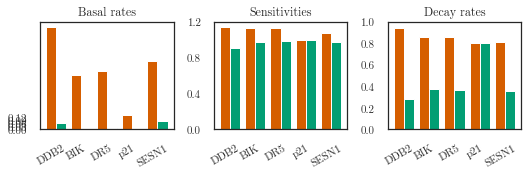

In [14]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())

plotter.plot_double_bar(kinetics, labels, ground_truths=p53_ground_truth(),
                        figsize=(7.5, 2.6),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])
plt.tight_layout()
plt.savefig('./kinetics.pdf', **tight_kwargs)

In [ ]:
 # key in ['basal_rate', 'sensitivity', 'decay_rate']:
plt.plot(lfm.positivity.transform(torch.stack(trainer.parameter_trace['raw_basal'])[:, 3]))
plt.tight_layout()

In [ ]:
print(lfm.basal_rate)

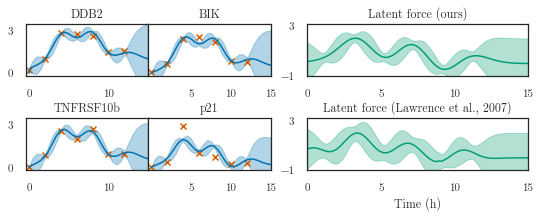

In [95]:
## This stuff is safe to delete:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 2.7),
                         gridspec_kw=dict(width_ratios=[1, 1, 0.3, 1.8], wspace=0, hspace=0.8))

row = 0
col = 0
ub = [3.5] * 4
for i in range(4):
    if i == 2:
        row += 1
        col = 0
    ax = axes[row, col]
    plotter.plot_gp(q_m, t_predict, replicate=0, ax=ax,
                    color=Colours.line_color, shade_color=Colours.shade_color,
                    t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                    num_samples=0, only_plot_index=i)
    ax.set_ylim([-0.2, ub[i]])
    ax.set_yticks([0, 3])
    ax.set_title(dataset.gene_names[i])
    ax.set_xlim(-0.4, 15)
    if col > 0:
        ax.set_yticks([])
        ax.set_xticks([5, 10, 15])

    col += 1
plotter.plot_gp(q_f, t_predict, ax=axes[0, 3],
                ylim=(-1, 3.2),
                num_samples=0,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color)
plotter.plot_gp(exact_q_f, t_predict, ax=axes[1, 3],
                ylim=(-1, 3.2), color=Colours.line2_color,
                shade_color=Colours.shade2_color)
titles = ['ours', 'Lawrence et al., 2007']
for i in range(2):
    axes[i, 3].set_title(f'Latent force ({titles[i]})')
    axes[i, 3].set_yticks([-1, 3])
    axes[i, 3].set_xlim(0, 15)
    axes[i, 3].set_xticks([0, 5, 10, 15])
    axes[i, 2].set_visible(False)
axes[1, 3].set_xlabel('Time (h)')

plt.savefig('./barenco-combined.pdf', **tight_kwargs)
